# # Feature Engineering for Fraud Detection

# ## 1. Setup and Data Loading

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
import os
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Feature Engineering - Setup Complete")

# %%
# Load preprocessed data from EDA
try:
    fraud_data = pd.read_csv('data/processed/fraud_data_clean.csv')
except FileNotFoundError:
    fraud_data = pd.read_csv('data/raw/Fraud_Data.csv')
    fraud_data['signup_time'] = pd.to_datetime(fraud_data['signup_time'])
    fraud_data['purchase_time'] = pd.to_datetime(fraud_data['purchase_time'])

creditcard_data = pd.read_csv('data/raw/creditcard.csv')
ip_country = pd.read_csv('data/raw/IpAddress_to_Country.csv')

print(f"Fraud Data Shape: {fraud_data.shape}")
print(f"Credit Card Data Shape: {creditcard_data.shape}")

Feature Engineering - Setup Complete
Fraud Data Shape: (151112, 11)
Credit Card Data Shape: (284807, 31)


# ## 2. E-commerce Data Feature Engineering

In [3]:
def engineer_fraud_data_features(data, ip_country_df):
    """
    Create comprehensive features for e-commerce fraud data
    """
    print("Engineering features for e-commerce fraud data...")
    df = data.copy()
    
    # ========== TIME-BASED FEATURES ==========
    print("1. Creating time-based features...")
    
    # Purchase time features
    df['purchase_hour'] = df['purchase_time'].dt.hour
    df['purchase_day'] = df['purchase_time'].dt.dayofweek  # Monday=0, Sunday=6
    df['purchase_dayofmonth'] = df['purchase_time'].dt.day
    df['purchase_month'] = df['purchase_time'].dt.month
    
    # Signup time features
    df['signup_hour'] = df['signup_time'].dt.hour
    df['signup_day'] = df['signup_time'].dt.dayofweek
    
    # Temporal flags
    df['is_weekend'] = df['purchase_day'].isin([5, 6]).astype(int)
    df['is_night'] = ((df['purchase_hour'] >= 22) | (df['purchase_hour'] <= 6)).astype(int)
    df['is_business_hours'] = ((df['purchase_hour'] >= 9) & (df['purchase_hour'] <= 17)).astype(int)
    
    # Time difference features
    df['time_since_signup'] = (df['purchase_time'] - df['signup_time']).dt.total_seconds() / 3600  # hours
    
    # Same day/rapid purchase flags
    df['same_day_signup'] = (df['purchase_time'].dt.date == df['signup_time'].dt.date).astype(int)
    df['within_1h_signup'] = (df['time_since_signup'] <= 1).astype(int)
    df['within_24h_signup'] = (df['time_since_signup'] <= 24).astype(int)
    
    # Hour difference
    df['hour_diff_signup_purchase'] = abs(df['purchase_hour'] - df['signup_hour'])
    
    # ========== USER BEHAVIOR FEATURES ==========
    print("2. Creating user behavior features...")
    
    # Transaction frequency features
    user_transaction_counts = df['user_id'].value_counts()
    df['user_transaction_count'] = df['user_id'].map(user_transaction_counts)
    
    # Device usage features
    device_transaction_counts = df['device_id'].value_counts()
    df['device_transaction_count'] = df['device_id'].map(device_transaction_counts)
    df['device_uniqueness'] = 1 / df['device_transaction_count']  # Rare devices get higher scores
    
    # ========== TRANSACTION VALUE FEATURES ==========
    print("3. Creating transaction value features...")
    
    # Value categories and flags
    df['purchase_value_log'] = np.log1p(df['purchase_value'])
    
    # Percentile-based flags
    df['high_value_flag'] = (df['purchase_value'] > df['purchase_value'].quantile(0.95)).astype(int)
    df['low_value_flag'] = (df['purchase_value'] < df['purchase_value'].quantile(0.05)).astype(int)
    df['medium_value_flag'] = ((df['purchase_value'] >= df['purchase_value'].quantile(0.25)) & 
                              (df['purchase_value'] <= df['purchase_value'].quantile(0.75))).astype(int)
    
    # Value categories
    df['purchase_category'] = pd.qcut(df['purchase_value'], q=5, labels=[1, 2, 3, 4, 5])
    
    # ========== DEMOGRAPHIC FEATURES ==========
    print("4. Creating demographic features...")
    
    # Age groups
    df['age_group'] = pd.cut(df['age'], 
                            bins=[0, 18, 25, 35, 50, 65, 100],
                            labels=['<18', '18-25', '26-35', '36-50', '51-65', '65+'])
    
    # Age flags
    df['young_adult'] = ((df['age'] >= 18) & (df['age'] <= 25)).astype(int)
    df['middle_aged'] = ((df['age'] >= 35) & (df['age'] <= 50)).astype(int)
    df['senior'] = (df['age'] > 60).astype(int)
    
    # ========== BROWSER AND SOURCE FEATURES ==========
    print("5. Creating browser and source features...")
    
    # Browser risk scores (based on historical fraud rate)
    browser_fraud_rate = df.groupby('browser')['class'].mean()
    df['browser_risk_score'] = df['browser'].map(browser_fraud_rate).fillna(0)
    
    # Source risk scores
    source_fraud_rate = df.groupby('source')['class'].mean()
    df['source_risk_score'] = df['source'].map(source_fraud_rate).fillna(0)
    
    # Browser popularity
    browser_counts = df['browser'].value_counts(normalize=True)
    df['browser_popularity'] = df['browser'].map(browser_counts)
    
    # ========== GEOLOCATION FEATURES ==========
    print("6. Creating geolocation features...")
    
    # Function to convert IP to integer and find country
    def ip_to_int(ip_address):
        if ip_address == 'unknown' or pd.isna(ip_address):
            return None
        try:
            octets = list(map(int, ip_address.split('.')))
            return (octets[0] << 24) + (octets[1] << 16) + (octets[2] << 8) + octets[3]
        except:
            return None
    
    def find_country(ip_int, ip_country_df):
        if ip_int is None:
            return 'Unknown'
        
        ip_country_df = ip_country_df.sort_values('lower_bound_ip_address')
        low, high = 0, len(ip_country_df) - 1
        
        while low <= high:
            mid = (low + high) // 2
            lower_bound = ip_country_df.iloc[mid]['lower_bound_ip_address']
            upper_bound = ip_country_df.iloc[mid]['upper_bound_ip_address']
            
            if lower_bound <= ip_int <= upper_bound:
                return ip_country_df.iloc[mid]['country']
            elif ip_int < lower_bound:
                high = mid - 1
            else:
                low = mid + 1
        return 'Unknown'
    
    # Convert IP addresses and find countries (sample for speed)
    sample_size = min(5000, len(df))
    df_sample = df.head(sample_size).copy()
    df_sample['ip_int'] = df_sample['ip_address'].apply(ip_to_int)
    df_sample['country'] = df_sample['ip_int'].apply(lambda x: find_country(x, ip_country_df))
    
    # Calculate country risk scores
    if 'country' in df_sample.columns:
        country_fraud_rate = df_sample.groupby('country')['class'].mean()
        df['country_risk_score'] = df_sample['country'].map(country_fraud_rate).fillna(0)
    else:
        df['country_risk_score'] = 0
    
    # ========== INTERACTION FEATURES ==========
    print("7. Creating interaction features...")
    
    # Risk combinations
    df['high_risk_combo'] = ((df['browser_risk_score'] > df['browser_risk_score'].quantile(0.75)) & 
                            (df['source_risk_score'] > df['source_risk_score'].quantile(0.75))).astype(int)
    
    df['rapid_high_value'] = ((df['within_1h_signup'] == 1) & 
                             (df['high_value_flag'] == 1)).astype(int)
    
    df['night_high_value'] = ((df['is_night'] == 1) & 
                             (df['high_value_flag'] == 1)).astype(int)
    
    # ========== AGGREGATE FEATURES ==========
    print("8. Creating aggregate features...")
    
    # User-level aggregates
    user_agg = df.groupby('user_id').agg({
        'purchase_value': ['mean', 'std', 'count'],
        'time_since_signup': ['mean', 'min']
    }).fillna(0)
    
    user_agg.columns = ['user_avg_value', 'user_value_std', 'user_total_transactions', 
                       'user_avg_time_since_signup', 'user_first_time_since_signup']
    
    df = df.merge(user_agg, left_on='user_id', right_index=True, how='left')
    
    # Device-level aggregates
    device_agg = df.groupby('device_id').agg({
        'purchase_value': ['mean', 'count'],
        'user_id': 'nunique'
    }).fillna(0)
    
    device_agg.columns = ['device_avg_value', 'device_total_transactions', 'device_unique_users']
    df = df.merge(device_agg, left_on='device_id', right_index=True, how='left')
    
    # ========== RISK SCORE COMPOSITE ==========
    print("9. Creating composite risk score...")
    
    # Weighted risk score (simplified version)
    weights = {
        'browser_risk_score': 0.2,
        'source_risk_score': 0.2,
        'country_risk_score': 0.2,
        'within_1h_signup': 0.15,
        'high_value_flag': 0.15,
        'is_night': 0.1
    }
    
    df['composite_risk_score'] = sum(df[feature] * weight for feature, weight in weights.items())
    
    # ========== FEATURE SUMMARY ==========
    print(f"\nFeature Engineering Complete!")
    print(f"Original features: {len(data.columns)}")
    print(f"New features created: {len(df.columns) - len(data.columns)}")
    print(f"Total features: {len(df.columns)}")
    
    # List new features
    original_cols = set(data.columns)
    new_cols = set(df.columns) - original_cols
    print(f"\nNew features created: {len(new_cols)}")
    
    # Categorize new features
    feature_categories = {
        'Time-based': [col for col in new_cols if any(x in col for x in ['hour', 'day', 'time', 'weekend', 'night'])],
        'Behavioral': [col for col in new_cols if any(x in col for x in ['count', 'frequency', 'uniqueness'])],
        'Value-based': [col for col in new_cols if any(x in col for x in ['value', 'amount', 'category'])],
        'Risk-based': [col for col in new_cols if 'risk' in col.lower() or 'combo' in col],
        'Demographic': [col for col in new_cols if 'age' in col or 'group' in col],
        'Aggregate': [col for col in new_cols if 'user_' in col or 'device_' in col]
    }
    
    print("\nFeature Categories:")
    for category, features in feature_categories.items():
        if features:
            print(f"  {category}: {len(features)} features")
    
    return df

print("="*80)
print("E-COMMERCE DATA FEATURE ENGINEERING")
print("="*80)

fraud_data_engineered = engineer_fraud_data_features(fraud_data, ip_country)

# Display sample of new features
print("\nSample of Engineered Features:")
sample_cols = [col for col in fraud_data_engineered.columns if col not in fraud_data.columns][:10]
display(fraud_data_engineered[['user_id', 'class'] + sample_cols].head())

E-COMMERCE DATA FEATURE ENGINEERING
Engineering features for e-commerce fraud data...
1. Creating time-based features...
2. Creating user behavior features...
3. Creating transaction value features...
4. Creating demographic features...
5. Creating browser and source features...
6. Creating geolocation features...
7. Creating interaction features...
8. Creating aggregate features...
9. Creating composite risk score...

Feature Engineering Complete!
Original features: 11
New features created: 42
Total features: 53

New features created: 42

Feature Categories:
  Time-based: 14 features
  Behavioral: 4 features
  Value-based: 10 features
  Risk-based: 5 features
  Demographic: 2 features
  Aggregate: 11 features

Sample of Engineered Features:


,user_id,class,purchase_hour,purchase_day,purchase_dayofmonth,purchase_month,signup_hour,signup_day,is_weekend,is_night,is_business_hours,time_since_signup
0,22058,0,2,5,18,4,22,1,1,1,0,1251.8561
1,333320,0,1,0,8,6,20,6,0,1,0,4.9844
2,1359,1,18,3,1,1,18,3,0,0,0,0.0003
3,150084,0,13,0,4,5,21,1,0,0,1,136.6903
4,221365,0,18,2,9,9,7,1,0,0,0,1211.5169


# ## 3. Credit Card Data Feature Engineering

In [4]:
def engineer_creditcard_features(data):
    """
    Create comprehensive features for credit card fraud data
    """
    print("Engineering features for credit card fraud data...")
    df = data.copy()
    
    # ========== TIME-BASED FEATURES ==========
    print("1. Creating time-based features...")
    
    # Convert time to meaningful units
    df['transaction_hour'] = (df['Time'] // 3600) % 24
    df['transaction_day_hour'] = df['Time'] // 3600
    df['transaction_minute'] = df['Time'] // 60
    
    # Temporal flags
    df['is_night'] = ((df['transaction_hour'] >= 22) | (df['transaction_hour'] <= 6)).astype(int)
    df['is_business_hours'] = ((df['transaction_hour'] >= 9) & (df['transaction_hour'] <= 17)).astype(int)
    df['is_weekend_hour'] = ((df['transaction_day_hour'] % (24*7)) >= (24*5)).astype(int)  # Friday 5PM onwards
    
    # Time cycles
    df['hour_of_day_sin'] = np.sin(2 * np.pi * df['transaction_hour'] / 24)
    df['hour_of_day_cos'] = np.cos(2 * np.pi * df['transaction_hour'] / 24)
    
    # ========== AMOUNT-BASED FEATURES ==========
    print("2. Creating amount-based features...")
    
    # Transformations
    df['amount_log'] = np.log1p(df['Amount'])
    df['amount_sqrt'] = np.sqrt(df['Amount'] + 1)
    
    # Statistical transformations
    df['amount_scaled'] = (df['Amount'] - df['Amount'].mean()) / df['Amount'].std()
    df['amount_robust'] = (df['Amount'] - df['Amount'].median()) / (df['Amount'].quantile(0.75) - df['Amount'].quantile(0.25))
    
    # Amount categories and flags
    df['high_amount_flag'] = (df['Amount'] > df['Amount'].quantile(0.95)).astype(int)
    df['low_amount_flag'] = (df['Amount'] < df['Amount'].quantile(0.05)).astype(int)
    df['amount_category'] = pd.qcut(df['Amount'], q=5, labels=[1, 2, 3, 4, 5])
    
    # ========== TIME SINCE LAST TRANSACTION ==========
    print("3. Creating time difference features...")
    
    # Assuming sequential data, calculate time since last transaction
    df = df.sort_values('Time')
    df['time_since_last'] = df['Time'].diff().fillna(0)
    df['time_since_last_log'] = np.log1p(df['time_since_last'])
    
    # Time gap flags
    df['rapid_transaction'] = (df['time_since_last'] < 60).astype(int)  # Less than 1 minute
    df['long_gap'] = (df['time_since_last'] > 3600).astype(int)  # More than 1 hour
    
    # ========== ROLLING STATISTICS ==========
    print("4. Creating rolling statistics...")
    
    window_size = 1000
    
    # Rolling amount statistics
    df['amount_rolling_mean'] = df['Amount'].rolling(window=window_size, center=True, min_periods=1).mean()
    df['amount_rolling_std'] = df['Amount'].rolling(window=window_size, center=True, min_periods=1).std()
    df['amount_rolling_zscore'] = (df['Amount'] - df['amount_rolling_mean']) / df['amount_rolling_std'].replace(0, 1)
    
    # Rolling time statistics
    df['time_gap_rolling_mean'] = df['time_since_last'].rolling(window=window_size, center=True, min_periods=1).mean()
    
    # ========== PCA COMPONENT INTERACTIONS ==========
    print("5. Creating PCA component interactions...")
    
    # Based on EDA, identify top correlated components
    pca_correlations = {}
    for col in [f'V{i}' for i in range(1, 29)]:
        pca_correlations[col] = df[col].corr(df['Class'])
    
    top_correlations = pd.Series(pca_correlations).abs().sort_values(ascending=False)
    top_positive = top_correlations.head(5).index.tolist()
    
    # Create interaction features between top components
    for i in range(len(top_positive)):
        for j in range(i+1, len(top_positive)):
            col1, col2 = top_positive[i], top_positive[j]
            df[f'{col1}_{col2}_interaction'] = df[col1] * df[col2]
            df[f'{col1}_{col2}_ratio'] = df[col1] / (df[col2].replace(0, 0.001))
    
    # Component aggregates
    df['pca_positive_sum'] = df[[f'V{i}' for i in range(1, 29)]].clip(lower=0).sum(axis=1)
    df['pca_negative_sum'] = df[[f'V{i}' for i in range(1, 29)]].clip(upper=0).sum(axis=1)
    df['pca_abs_sum'] = df[[f'V{i}' for i in range(1, 29)]].abs().sum(axis=1)
    
    # ========== ANOMALY DETECTION FEATURES ==========
    print("6. Creating anomaly detection features...")
    
    # Mahalanobis distance approximation (using top PCA components)
    from scipy.spatial.distance import mahalanobis
    
    # Use top 5 components for efficiency
    top_components = top_positive[:5]
    cov_matrix = df[top_components].cov().values
    cov_inv = np.linalg.pinv(cov_matrix)  # Pseudo-inverse for stability
    mean_vector = df[top_components].mean().values
    
    def calculate_mahalanobis(row):
        try:
            return mahalanobis(row[top_components].values, mean_vector, cov_inv)
        except:
            return 0
    
    df['mahalanobis_distance'] = df.apply(calculate_mahalanobis, axis=1)
    
    # Isolation Forest features (would be computed during modeling, but we can precompute)
    df['pca_magnitude'] = np.sqrt((df[top_components] ** 2).sum(axis=1))
    
    # ========== FRAUD CLUSTERING FEATURES ==========
    print("7. Creating fraud clustering features...")
    
    # Calculate distance to fraud cluster centroids (simplified)
    fraud_data = df[df['Class'] == 1]
    if len(fraud_data) > 0:
        fraud_centroid = fraud_data[top_components].mean().values
        
        def distance_to_fraud_centroid(row):
            return np.sqrt(((row[top_components].values - fraud_centroid) ** 2).sum())
        
        df['distance_to_fraud_centroid'] = df.apply(distance_to_fraud_centroid, axis=1)
    else:
        df['distance_to_fraud_centroid'] = 0
    
    # ========== STATISTICAL MOMENT FEATURES ==========
    print("8. Creating statistical moment features...")
    
    # Skewness and kurtosis of recent transactions
    window_size_small = 100
    
    # For top components
    for comp in top_positive[:3]:
        df[f'{comp}_rolling_skew'] = df[comp].rolling(window=window_size_small, center=True, min_periods=1).skew()
        df[f'{comp}_rolling_kurtosis'] = df[comp].rolling(window=window_size_small, center=True, min_periods=1).kurt()
    
    # ========== RISK SCORE COMPOSITE ==========
    print("9. Creating composite risk score...")
    
    # Simple heuristic risk score
    df['heuristic_risk_score'] = (
        df['high_amount_flag'] * 0.3 +
        df['rapid_transaction'] * 0.2 +
        df['is_night'] * 0.1 +
        df['amount_rolling_zscore'].abs().clip(upper=3) * 0.2 +
        (df['mahalanobis_distance'] / df['mahalanobis_distance'].quantile(0.95)).clip(upper=1) * 0.2
    )
    
    # ========== FEATURE SUMMARY ==========
    print(f"\nFeature Engineering Complete!")
    print(f"Original features: {len(data.columns)}")
    print(f"New features created: {len(df.columns) - len(data.columns)}")
    print(f"Total features: {len(df.columns)}")
    
    # List new features
    original_cols = set(data.columns)
    new_cols = set(df.columns) - original_cols
    print(f"\nNew features created: {len(new_cols)}")
    
    # Categorize new features
    feature_categories = {
        'Time-based': [col for col in new_cols if any(x in col for x in ['hour', 'time', 'night', 'gap'])],
        'Amount-based': [col for col in new_cols if any(x in col for x in ['amount', 'value'])],
        'PCA-interactions': [col for col in new_cols if 'interaction' in col or 'ratio' in col or 'pca_' in col],
        'Statistical': [col for col in new_cols if any(x in col for x in ['rolling', 'zscore', 'skew', 'kurtosis'])],
        'Anomaly': [col for col in new_cols if any(x in col for x in ['mahalanobis', 'distance', 'magnitude'])],
        'Risk': [col for col in new_cols if 'risk' in col.lower() or 'flag' in col]
    }
    
    print("\nFeature Categories:")
    for category, features in feature_categories.items():
        if features:
            print(f"  {category}: {len(features)} features")
    
    return df

print("\n" + "="*80)
print("CREDIT CARD DATA FEATURE ENGINEERING")
print("="*80)

creditcard_data_engineered = engineer_creditcard_features(creditcard_data)

# Display sample of new features
print("\nSample of Engineered Features:")
sample_cols = [col for col in creditcard_data_engineered.columns if col not in creditcard_data.columns][:10]
display(creditcard_data_engineered[['Time', 'Amount', 'Class'] + sample_cols].head())


CREDIT CARD DATA FEATURE ENGINEERING
Engineering features for credit card fraud data...
1. Creating time-based features...
2. Creating amount-based features...
3. Creating time difference features...
4. Creating rolling statistics...
5. Creating PCA component interactions...
6. Creating anomaly detection features...
7. Creating fraud clustering features...
8. Creating statistical moment features...
9. Creating composite risk score...

Feature Engineering Complete!
Original features: 31
New features created: 56
Total features: 87

New features created: 56

Feature Categories:
  Time-based: 11 features
  Amount-based: 10 features
  PCA-interactions: 24 features
  Statistical: 10 features
  Anomaly: 3 features
  Risk: 3 features

Sample of Engineered Features:


,Time,Amount,Class,transaction_hour,transaction_day_hour,transaction_minute,is_night,is_business_hours,is_weekend_hour,hour_of_day_sin,hour_of_day_cos,amount_log,amount_sqrt
0,0.0000,149.6200,0,0.0000,0.0000,0.0000,1,0,0,0.0000,1.0000,5.0148,12.2727
1,0.0000,2.6900,0,0.0000,0.0000,0.0000,1,0,0,0.0000,1.0000,1.3056,1.9209
2,1.0000,378.6600,0,0.0000,0.0000,0.0000,1,0,0,0.0000,1.0000,5.9393,19.4849
3,1.0000,123.5000,0,0.0000,0.0000,0.0000,1,0,0,0.0000,1.0000,4.8243,11.1580
4,2.0000,69.9900,0,0.0000,0.0000,0.0000,1,0,0,0.0000,1.0000,4.2625,8.4256


# ## 4. Feature Selection and Importance

FEATURE IMPORTANCE ANALYSIS

1. E-commerce Data Feature Importance:

Analyzing feature importance for E-commerce Fraud...
  Dataset shape: (151112, 52)
  Number of features: 52
  Categorical columns: 4
  Numerical columns: 44

  Processing numerical features...
    Batch 1: Processing 44 features

  Processing categorical features...
    Processing: device_id (unique values: 137956)
    Processing: source (unique values: 3)
    Processing: browser (unique values: 5)
    Processing: sex (unique values: 2)

  Preparing top features for mutual information calculation...
  Calculating mutual information...
  Creating visualizations...


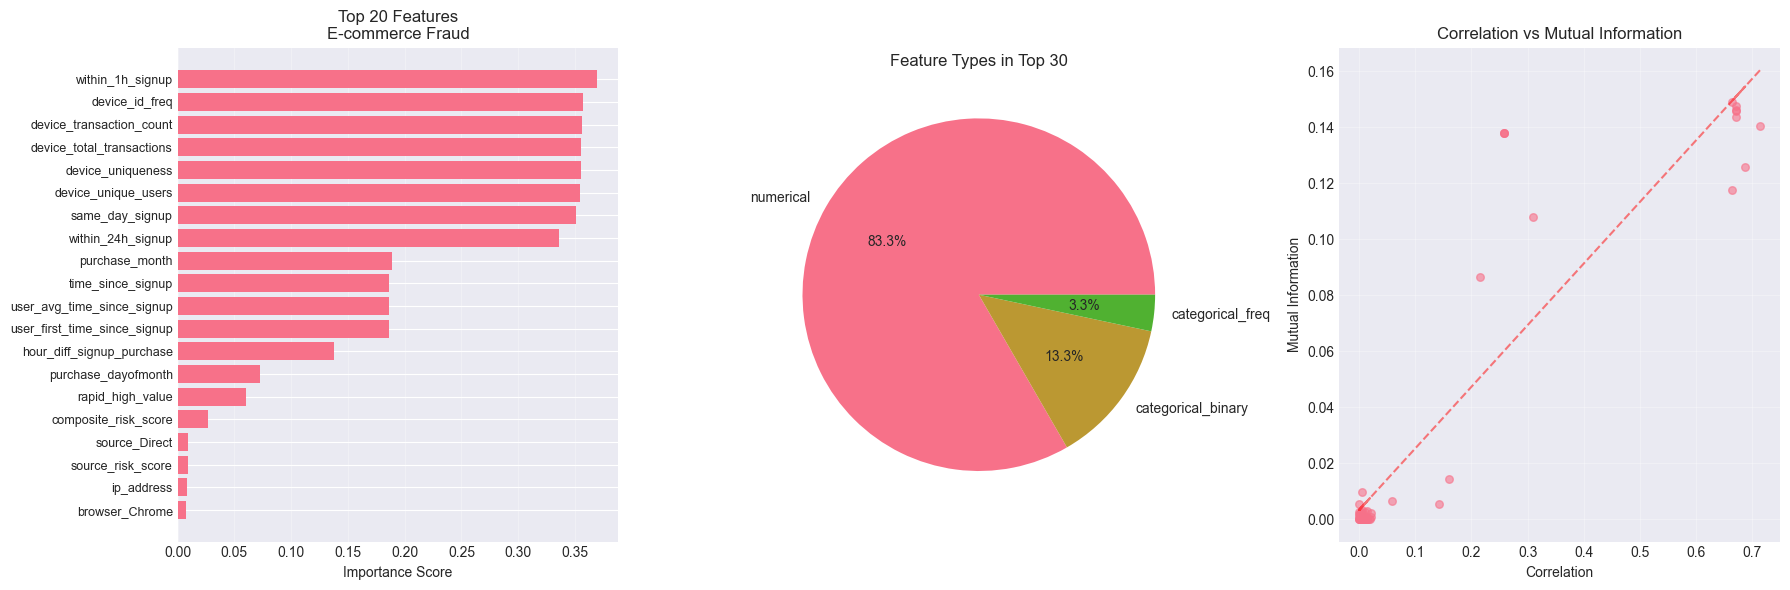


FEATURE IMPORTANCE RESULTS - E-commerce Fraud

Top 10 Most Important Features:
--------------------------------------------------------------------------------
16. within_1h_signup                         Score: 0.3698 (Corr: 0.714, MI: 0.140)
45. device_id_freq                           Score: 0.3568 (Corr: 0.671, MI: 0.147)
20. device_transaction_count                 Score: 0.3560 (Corr: 0.671, MI: 0.146)
42. device_total_transactions                Score: 0.3557 (Corr: 0.671, MI: 0.146)
21. device_uniqueness                        Score: 0.3553 (Corr: 0.665, MI: 0.149)
43. device_unique_users                      Score: 0.3546 (Corr: 0.671, MI: 0.144)
15. same_day_signup                          Score: 0.3507 (Corr: 0.688, MI: 0.126)
17. within_24h_signup                        Score: 0.3360 (Corr: 0.664, MI: 0.117)
 8. purchase_month                           Score: 0.1888 (Corr: 0.310, MI: 0.108)
14. time_since_signup                        Score: 0.1858 (Corr: 0.258, MI: 0.138)

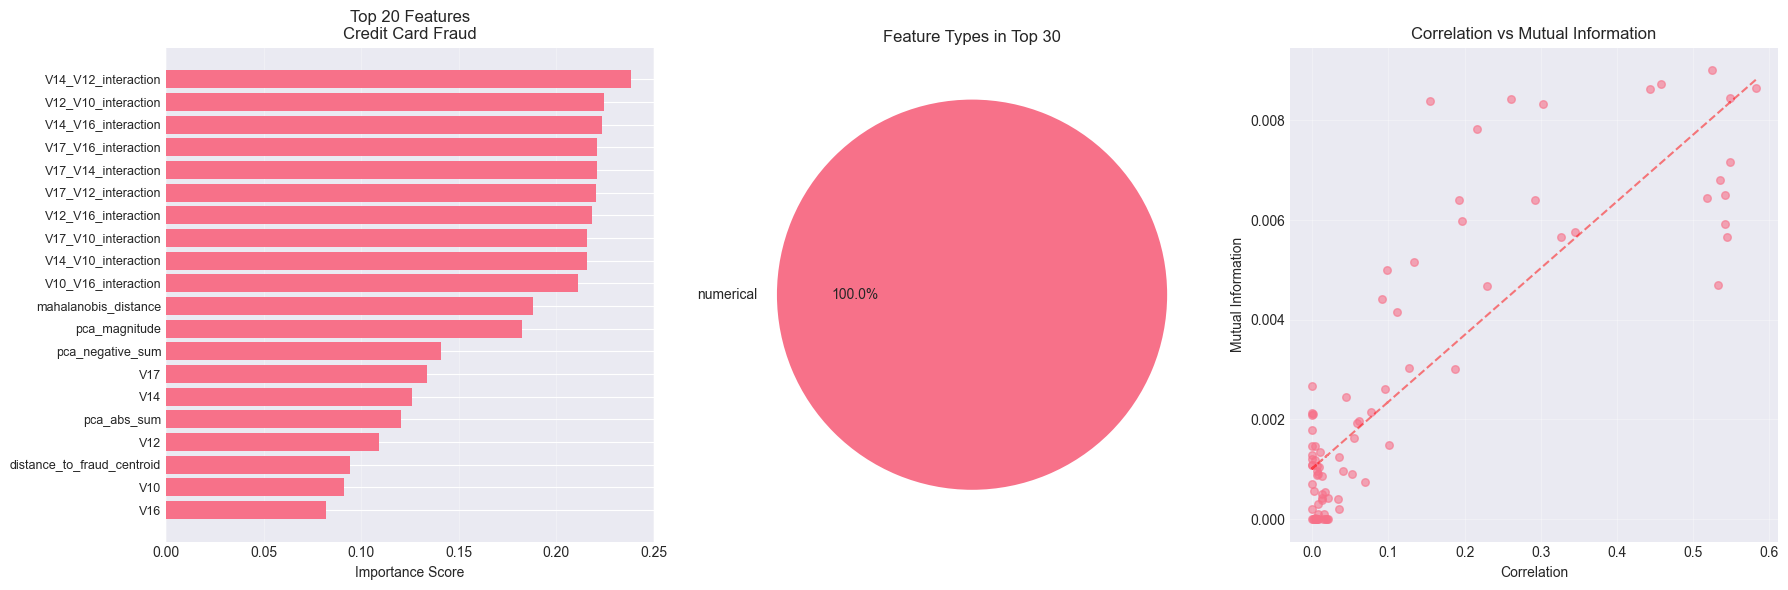


FEATURE IMPORTANCE RESULTS - Credit Card Fraud

Top 10 Most Important Features:
--------------------------------------------------------------------------------
61. V14_V12_interaction                      Score: 0.2383 (Corr: 0.583, MI: 0.009)
67. V12_V10_interaction                      Score: 0.2245 (Corr: 0.549, MI: 0.008)
65. V14_V16_interaction                      Score: 0.2238 (Corr: 0.549, MI: 0.007)
59. V17_V16_interaction                      Score: 0.2213 (Corr: 0.545, MI: 0.006)
53. V17_V14_interaction                      Score: 0.2209 (Corr: 0.543, MI: 0.007)
55. V17_V12_interaction                      Score: 0.2207 (Corr: 0.543, MI: 0.006)
69. V12_V16_interaction                      Score: 0.2185 (Corr: 0.536, MI: 0.007)
57. V17_V10_interaction                      Score: 0.2159 (Corr: 0.533, MI: 0.005)
63. V14_V10_interaction                      Score: 0.2157 (Corr: 0.526, MI: 0.009)
71. V10_V16_interaction                      Score: 0.2114 (Corr: 0.519, MI: 0.006

In [5]:
def analyze_feature_importance_minimal(data, target_col, dataset_name):
    """

    Processes features in batches and uses efficient encoding
    """
    print(f"\nAnalyzing feature importance for {dataset_name}...")
    
    # Separate features and target
    X = data.drop(columns=[target_col])
    y = data[target_col]
    
    print(f"  Dataset shape: {X.shape}")
    print(f"  Number of features: {len(X.columns)}")
    
    # Process features in batches to avoid memory issues
    batch_size = 50
    all_importance_scores = []
    
    # Categorical columns need special handling
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    
    print(f"  Categorical columns: {len(categorical_cols)}")
    print(f"  Numerical columns: {len(numerical_cols)}")
    
    # Process numerical columns first (they're memory efficient)
    print("\n  Processing numerical features...")
    for i in range(0, len(numerical_cols), batch_size):
        batch_cols = numerical_cols[i:i+batch_size]
        print(f"    Batch {i//batch_size + 1}: Processing {len(batch_cols)} features")
        
        X_batch = X[batch_cols].copy()
        
        # Fill missing values
        X_batch = X_batch.fillna(X_batch.median())
        
        # Calculate correlation for each feature
        for col in batch_cols:
            corr = X_batch[col].corr(y)
            if pd.isna(corr):
                corr = 0
            
            all_importance_scores.append({
                'feature': col,
                'correlation': abs(corr),
                'mutual_info': 0,  # Will calculate later if needed
                'feature_type': 'numerical'
            })
    
    # Process categorical columns with smart encoding
    print("\n  Processing categorical features...")
    for col in categorical_cols:
        print(f"    Processing: {col} (unique values: {X[col].nunique()})")
        
        if X[col].nunique() > 100:
            # High cardinality: use frequency encoding
            freq = X[col].value_counts(normalize=True)
            X_encoded = X[col].map(freq).fillna(0)
            
            # Calculate correlation
            corr = X_encoded.corr(y) if X_encoded.var() > 0 else 0
            
            all_importance_scores.append({
                'feature': f'{col}_freq',
                'correlation': abs(corr) if not pd.isna(corr) else 0,
                'mutual_info': 0,
                'feature_type': 'categorical_freq'
            })
            
        elif X[col].nunique() > 2:
            # Medium cardinality: create binary indicators for top categories
            top_categories = X[col].value_counts().head(5).index
            
            for category in top_categories:
                indicator = (X[col] == category).astype(int)
                if indicator.var() > 0:  # Only if there's variance
                    corr = indicator.corr(y)
                    all_importance_scores.append({
                        'feature': f'{col}_{category}',
                        'correlation': abs(corr) if not pd.isna(corr) else 0,
                        'mutual_info': 0,
                        'feature_type': 'categorical_binary'
                    })
        else:
            # Binary categorical: encode as 0/1
            from sklearn.preprocessing import LabelEncoder
            le = LabelEncoder()
            X_encoded = le.fit_transform(X[col].fillna('missing').astype(str))
            
            # Convert to pandas series for correlation
            X_encoded_series = pd.Series(X_encoded, index=X.index)
            if X_encoded_series.var() > 0:
                corr = X_encoded_series.corr(y)
                all_importance_scores.append({
                    'feature': col,
                    'correlation': abs(corr) if not pd.isna(corr) else 0,
                    'mutual_info': 0,
                    'feature_type': 'categorical_binary'
                })
    
    # Create importance dataframe
    importance_df = pd.DataFrame(all_importance_scores)
    
    # Calculate combined score
    importance_df['combined_score'] = importance_df['correlation']
    
    # Sort by importance
    importance_df = importance_df.sort_values('combined_score', ascending=False)
    
    # Select top features for mutual information calculation
    top_features = importance_df.head(100)['feature'].tolist()
    
    # Reconstruct top features for MI calculation
    print("\n  Preparing top features for mutual information calculation...")
    X_top = pd.DataFrame(index=X.index)
    
    for feature_info in importance_df.head(100).to_dict('records'):
        feature_name = feature_info['feature']
        
        if '_freq' in feature_name:
            # Reconstruct frequency encoded feature
            original_col = feature_name.replace('_freq', '')
            freq = X[original_col].value_counts(normalize=True)
            X_top[feature_name] = X[original_col].map(freq).fillna(0)
            
        elif '_' in feature_name and feature_info['feature_type'] == 'categorical_binary':
            # Reconstruct binary indicator
            parts = feature_name.split('_')
            original_col = '_'.join(parts[:-1])
            category = parts[-1]
            X_top[feature_name] = (X[original_col] == category).astype(int)
            
        elif feature_name in numerical_cols:
            # Numerical feature
            X_top[feature_name] = X[feature_name].fillna(X[feature_name].median())
            
        elif feature_name in categorical_cols:
            # Binary categorical (already encoded)
            from sklearn.preprocessing import LabelEncoder
            le = LabelEncoder()
            X_top[feature_name] = le.fit_transform(X[feature_name].fillna('missing').astype(str))
    
    # Fill any remaining missing values
    X_top = X_top.fillna(0)
    
    # Calculate mutual information for top features
    print("  Calculating mutual information...")
    from sklearn.feature_selection import mutual_info_classif
    
    # Use a sample if dataset is large
    if len(X_top) > 10000:
        sample_indices = np.random.choice(len(X_top), 10000, replace=False)
        X_sample = X_top.iloc[sample_indices]
        y_sample = y.iloc[sample_indices]
    else:
        X_sample = X_top
        y_sample = y
    
    mi_scores = mutual_info_classif(
        X_sample, 
        y_sample, 
        random_state=42,
        n_neighbors=5
    )
    
    # Update mutual information scores
    mi_dict = dict(zip(top_features, mi_scores))
    importance_df['mutual_info'] = importance_df['feature'].map(mi_dict).fillna(0)
    
    # Recalculate combined score with mutual information
    importance_df['combined_score'] = (
        importance_df['correlation'] * 0.4 + 
        importance_df['mutual_info'] * 0.6
    )
    
    importance_df = importance_df.sort_values('combined_score', ascending=False)
    
    # Create visualizations
    print("  Creating visualizations...")
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Top 20 features
    top_20 = importance_df.head(20)
    axes[0].barh(range(len(top_20)), top_20['combined_score'].values[::-1])
    axes[0].set_yticks(range(len(top_20)))
    axes[0].set_yticklabels(top_20['feature'].values[::-1], fontsize=9)
    axes[0].set_xlabel('Importance Score')
    axes[0].set_title(f'Top 20 Features\n{dataset_name}')
    axes[0].grid(True, alpha=0.3, axis='x')
    
    # Feature type distribution in top 30
    top_30_types = importance_df.head(30)['feature_type'].value_counts()
    axes[1].pie(top_30_types.values, labels=top_30_types.index, autopct='%1.1f%%')
    axes[1].set_title('Feature Types in Top 30')
    
    # Correlation vs Mutual Info
    axes[2].scatter(importance_df['correlation'], importance_df['mutual_info'], alpha=0.6, s=30)
    axes[2].set_xlabel('Correlation')
    axes[2].set_ylabel('Mutual Information')
    axes[2].set_title('Correlation vs Mutual Information')
    axes[2].grid(True, alpha=0.3)
    
    # Add trend line
    if len(importance_df) > 1:
        z = np.polyfit(importance_df['correlation'], importance_df['mutual_info'], 1)
        p = np.poly1d(z)
        axes[2].plot(importance_df['correlation'], p(importance_df['correlation']), "r--", alpha=0.5)
    
    plt.tight_layout()
    plt.savefig(f'plots/feature_importance_{dataset_name.replace(" ", "_")}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print results
    print(f"\n{'='*60}")
    print(f"FEATURE IMPORTANCE RESULTS - {dataset_name}")
    print(f"{'='*60}")
    
    print(f"\nTop 10 Most Important Features:")
    print("-" * 80)
    for idx, row in importance_df.head(10).iterrows():
        print(f"{idx+1:2d}. {row['feature']:40s} "
              f"Score: {row['combined_score']:.4f} "
              f"(Corr: {row['correlation']:.3f}, MI: {row['mutual_info']:.3f})")
    
    print(f"\nFeature Type Breakdown:")
    print("-" * 80)
    type_summary = importance_df['feature_type'].value_counts()
    for feature_type, count in type_summary.items():
        percentage = count / len(importance_df) * 100
        print(f"{feature_type:20s}: {count:4d} features ({percentage:.1f}%)")
    
    # Save results
    output_path = f'data/processed/feature_importance_{dataset_name.replace(" ", "_")}.csv'
    importance_df.to_csv(output_path, index=False)
    print(f"\nResults saved to: {output_path}")
    
    return importance_df
# Analyze feature importance for both datasets
print("="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)

print("\n1. E-commerce Data Feature Importance:")
fraud_importance = analyze_feature_importance_minimal(fraud_data_engineered, 'class', 'E-commerce Fraud')

print("\n2. Credit Card Data Feature Importance:")
credit_importance = analyze_feature_importance_minimal(creditcard_data_engineered, 'Class', 'Credit Card Fraud')

# ## 5. Data Transformation and Scaling

In [6]:
def prepare_data_for_modeling(data, target_col, dataset_name):
    """
    Prepare engineered data for modeling with proper transformations
    """
    print(f"\nPreparing {dataset_name} data for modeling...")
    
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    from sklearn.impute import SimpleImputer
    
    df = data.copy()
    
    # Separate features and target
    y = df[target_col]
    X = df.drop(columns=[target_col])
    
    # Identify column types
    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    
    print(f"  Total samples: {len(X)}")
    print(f"  Numeric features: {len(numeric_cols)}")
    print(f"  Categorical features: {len(categorical_cols)}")
    
    # ========== HANDLE CATEGORICAL FEATURES ==========
    print("  Encoding categorical features...")
    
    # For high cardinality columns, use frequency encoding
    for col in categorical_cols:
        if X[col].nunique() > 10:
            # Frequency encoding
            freq_encoding = X[col].value_counts(normalize=True)
            X[f'{col}_freq'] = X[col].map(freq_encoding)
            X = X.drop(columns=[col])
        else:
            # One-hot encoding for low cardinality
            dummies = pd.get_dummies(X[col], prefix=col, drop_first=True)
            X = pd.concat([X.drop(columns=[col]), dummies], axis=1)
    
    # Update categorical columns
    categorical_cols = [col for col in categorical_cols if col in X.columns]
    
    # ========== HANDLE MISSING VALUES ==========
    print("  Handling missing values...")
    
    for col in X.columns:
        if X[col].isnull().any():
            if pd.api.types.is_numeric_dtype(X[col]):
                X[col].fillna(X[col].median(), inplace=True)
            else:
                X[col].fillna(X[col].mode()[0] if len(X[col].mode()) > 0 else 0, inplace=True)
    
    # ========== SCALE NUMERICAL FEATURES ==========
    print("  Scaling numerical features...")
    
    # Different scaling strategies for different feature types
    from sklearn.preprocessing import RobustScaler
    
    # Identify columns that might have outliers
    outlier_prone_cols = []
    for col in X.select_dtypes(include=['int64', 'float64']).columns:
        if 'value' in col.lower() or 'amount' in col.lower() or 'time' in col.lower():
            outlier_prone_cols.append(col)
    
    # Use RobustScaler for outlier-prone features, StandardScaler for others
    scaler_dict = {}
    
    for col in X.select_dtypes(include=['int64', 'float64']).columns:
        if col in outlier_prone_cols:
            scaler = RobustScaler()
        else:
            scaler = StandardScaler()
        
        X[col] = scaler.fit_transform(X[[col]])
        scaler_dict[col] = scaler
    
    print(f"\n  Final feature matrix shape: {X.shape}")
    print(f"  Target variable shape: {y.shape}")
    
    return X, y, scaler_dict

# Prepare both datasets
print("="*80)
print("DATA PREPARATION FOR MODELING")
print("="*80)

print("\n1. E-commerce Data Preparation:")
X_fraud, y_fraud, fraud_scalers = prepare_data_for_modeling(
    fraud_data_engineered, 'class', 'E-commerce Fraud'
)

print("\n2. Credit Card Data Preparation:")
X_credit, y_credit, credit_scalers = prepare_data_for_modeling(
    creditcard_data_engineered, 'Class', 'Credit Card Fraud'
)


DATA PREPARATION FOR MODELING

1. E-commerce Data Preparation:

Preparing E-commerce Fraud data for modeling...
  Total samples: 151112
  Numeric features: 37
  Categorical features: 6
  Encoding categorical features...
  Handling missing values...
  Scaling numerical features...

  Final feature matrix shape: (151112, 63)
  Target variable shape: (151112,)

2. Credit Card Data Preparation:

Preparing Credit Card Fraud data for modeling...
  Total samples: 284807
  Numeric features: 85
  Categorical features: 1
  Encoding categorical features...
  Handling missing values...
  Scaling numerical features...

  Final feature matrix shape: (284807, 89)
  Target variable shape: (284807,)


# ## 6. Save Processed Data

In [7]:
def save_processed_data(X, y, dataset_name):
    """Save processed data for modeling"""
    import os
    
    # Create processed data directory
    os.makedirs('data/processed', exist_ok=True)
    
    # Combine features and target
    processed_data = pd.concat([X, y], axis=1)
    
    # Save to CSV
    filename = f'data/processed/{dataset_name.lower().replace(" ", "_")}_processed.csv'
    processed_data.to_csv(filename, index=False)
    
    print(f"  ✓ Saved to {filename}")
    
    # Save feature list
    feature_list = X.columns.tolist()
    feature_filename = f'data/processed/{dataset_name.lower().replace(" ", "_")}_features.txt'
    with open(feature_filename, 'w') as f:
        for feature in feature_list:
            f.write(f"{feature}\n")
    
    print(f"  ✓ Feature list saved to {feature_filename}")
    
    return filename

print("="*80)
print("SAVING PROCESSED DATA")
print("="*80)

print("\nSaving processed datasets...")
fraud_data_path = save_processed_data(X_fraud, y_fraud, 'fraud_data')
credit_data_path = save_processed_data(X_credit, y_credit, 'creditcard_data')

print("\n" + "="*80)
print("FEATURE ENGINEERING COMPLETED!")
print("="*80)
print(f"\nSummary:")
print(f"  E-commerce features: {X_fraud.shape[1]} total features")
print(f"  Credit card features: {X_credit.shape[1]} total features")
print(f"\nProcessed data saved to:")
print(f"  {fraud_data_path}")
print(f"  {credit_data_path}")
print(f"\nNext step: Proceed to modeling.ipynb")

SAVING PROCESSED DATA

Saving processed datasets...
  ✓ Saved to data/processed/fraud_data_processed.csv
  ✓ Feature list saved to data/processed/fraud_data_features.txt
  ✓ Saved to data/processed/creditcard_data_processed.csv
  ✓ Feature list saved to data/processed/creditcard_data_features.txt

FEATURE ENGINEERING COMPLETED!

Summary:
  E-commerce features: 63 total features
  Credit card features: 89 total features

Processed data saved to:
  data/processed/fraud_data_processed.csv
  data/processed/creditcard_data_processed.csv

Next step: Proceed to modeling.ipynb
